In [1]:
# Standard Library Imports (if any)

# Third-party Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display, HTML
from adjustText import adjust_text
from sklearn.preprocessing import StandardScaler
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects

# Local Module Imports
from utils import *
from new_data_handling import DataManager
from plot import *
from new_data_handling.data_processor import *

In [ ]:
major = COUNTRIES.MAJOR
offshore = COUNTRIES.OFFSHORE
sample = major + offshore
period = (2001, 2004)
save = None
interpolate = False
dm = DataManager(
    raw_dir = "../data/raw",
    save_dir = "../data/clean"
)
ds_full = dm.get_dataset("ds")
fed_full = dm.get_dataset("fed")
# dm.clean_data()
# dm.save_data()

In [59]:
# Index returns
period = (2001, 2004)
ds = dm.ds.get_data(period=period, interval="M")
fed = dm.fed.get_data(period=period)
panel_dates = fed.columns
returns_index = compute_index_excess_returns(ds, fed, major)
returns_index = returns_index.stack().rename("returns")

# # Portfolio returns
# period = (2001, 2004)
# cpis = dm.cpis.get_data(period=period)
# wb = dm.wb.get_data(countries=major, period=period)
# weights = compute_weights(cpis, wb, major, offshore).mean(axis=1).unstack(level="Country")
# returns_portfolio = compute_portfolio_excess_returns(ds, fed, major, weights)

# World market return
returns_world = compute_index_excess_returns(ds, fed, ["WR"]).to_numpy().flatten()
returns_world_dummies = pd.DataFrame(0.0, index=returns_index.index, columns=major)
for country in major:
    returns_world_dummies.loc[(country, slice(None)), country] = returns_world
returns_world_dummies.columns = ['WRx' + str(col) for col in returns_world_dummies.columns]

# GDP per capita
interpolate=False
period = (2001, 2004) if not interpolate else (2000,2004)
gdp_cap_ppp = dm.gdp.get_data(countries=major, period=period, gdp_type="gdp_cap_ppp")
gdp_cap_ppp = create_monthly_duplicates(gdp_cap_ppp, panel_dates, interpolate=interpolate)
gdp_cap_ppp = gdp_cap_ppp.stack().rename("gdp_cap")

# GDP growth (lagged yearly)
d_gdp_ppp_lag = pd.DataFrame(index=returns_index.index)
lags = range(1,2)
for lag in lags:
    period = (2000-lag,2004-lag)
    gdp_ppp = dm.gdp.get_data(countries=major, period=period, gdp_type="gdp_ppp")
    d_gdp_ppp = (gdp_ppp.diff(axis=1) / gdp_ppp).iloc[:,1:]
    d_gdp_ppp = create_monthly_duplicates(d_gdp_ppp, panel_dates, interpolate=interpolate)
    d_gdp_ppp_lag[f"d_gdp_{lag}"] = d_gdp_ppp.stack().rename(f"lag{lag}")

# GDP growth (lagged monthly)
# d_gdp_ppp_lag = pd.DataFrame(index=returns_index.index)
# period = (1997,2004)
# n_lags = (2001 - period[0])*12
# columns = dm.ds.get_data(period=period, interval="M").columns[13:]
# d_gdp_ppp_lag = pd.DataFrame(index=returns_index.index)
# gdp_ppp = dm.gdp.get_data(countries=major, period=period, gdp_type="gdp_ppp")
# d_gdp_ppp = (gdp_ppp.diff(axis=1) / gdp_ppp).iloc[:,1:]
# d_gdp_ppp = create_monthly_duplicates(d_gdp_ppp, monthly_columns=columns, interpolate=interpolate)
# d_gdp_ppp
# lags = range(1, 37)
# for lag in lags:
#     d_gdp_ppp_lag[f"d_gdp_{lag}"] = d_gdp_ppp.iloc[:, 36-lag:-lag].T.unstack().to_numpy()
# d_gdp_ppp_lag = d_gdp_ppp_lag.iloc[:, range(0,1)]

# Variances (rolling window, exponential decay)
period = (1996,2004)
ds = dm.ds.get_data(period=period, interval="M")
fed = dm.fed.get_data(period=period)
returns_index_historical = compute_index_excess_returns(ds, fed, major)
variances = pd.DataFrame(index=major, columns=panel_dates)
for i in range(48):
    returns = returns_index_historical.iloc[:,i:i+60]
    means = returns.mean(axis=1)
    returns_demeaned = returns.sub(means, axis=0)
    var_contributions = returns_demeaned**2
    factors = generate_exponential_decay(ratio=0.95)
    vars = var_contributions.mul(factors).sum(axis=1) / sum(factors)
    variances.iloc[:,i] = vars
variances = variances.stack().rename("variances")

In [60]:
# Collect dependent and independent variables
scale = True
y = returns_index * (1e2 if scale else 1)
X = pd.concat([
    returns_world_dummies * (1e2 if scale else 1),
    # gdp_cap_ppp / (1e5 if scale else 1),
    d_gdp_ppp_lag * (1e2 if scale else 1),
    variances * (1e2 if scale else 1),
], axis=1)
X = sm.add_constant(X)

In [61]:
# Do statistics
from linearmodels.panel import PanelOLS, PooledOLS

model_panel = PanelOLS(y, X, entity_effects=True).fit(cov_type="kernel", kernel="bartlett", bandwidth=4)
model_pooled = PooledOLS(y,X).fit(cov_type="kernel", kernel="bartlett", bandwidth=4)

comparison = pd.DataFrame([model_pooled.params, model_panel.params], index=["pooled", "panel"])
date = model_panel.estimated_effects.index.get_level_values(1)[0]

effects = model_panel.estimated_effects.loc[(slice(None), date),:].droplevel(1)

if save is not None:
    save_dir = f"./output/exp3/results/"
    os.makedirs(save_dir, exist_ok=True)
    print(save_dir)
    with open(os.path.join(save_dir, f"{save}.txt"), "w") as f:
        f.write(model_panel.summary.as_text())
model_panel.summary

Dep. Variable:,returns,R-squared:,0.4457
Estimator:,PanelOLS,R-squared (Between):,-0.3956
No. Observations:,1824,R-squared (Within):,0.4457
Date:,"Sun, Apr 20 2025",R-squared (Overall):,0.4338
Time:,23:50:09,Log-likelihood,-5778.3
Cov. Estimator:,Driscoll-Kraay,,
,,F-statistic:,35.105
Entities:,38,P-value,0.0000
Avg Obs:,48.000,Distribution:,"F(40,1746)"
Min Obs:,48.000,,
Max Obs:,48.000,F-statistic (robust):,2.794e+05


In [62]:
# Expected world return
period = (1991,2004)
ds = dm.ds.get_data(period=period, interval="M")
fed = dm.fed.get_data(period=period)
returns_world = compute_index_excess_returns(ds, fed, ["WR"])
returns_world_expectation = np.zeros(48)
for i in range(48):
    returns = returns_world.iloc[:,i:i+120]
    mean = returns.mean(axis=1).iloc[0]
    returns_world_expectation[i] = mean

In [63]:
params_for_estimation = model_panel.params.copy()
X_for_estimation = X.copy()
for country in major:
    world_return_header = "WRx" + country
    X_for_estimation.loc[(country, slice(None)), world_return_header] = returns_world_expectation
fitted_returns = (X_for_estimation * params_for_estimation)
fitted_returns = fitted_returns.sum(axis=1).unstack()
(fitted_returns < 0).sum(axis=1)

AR     0
AT     0
BE     0
BR     0
CA     0
CH     0
CL     0
CO     0
CZ     0
DE     0
DK     0
ES     0
FI     0
FR     0
GB     8
GR     0
HK     0
HU     0
ID     0
IL     2
IT     0
JP     0
KR     0
MX     0
MY    12
NL     0
NO     0
PH     0
PL     0
PT     0
RU     0
SE     0
SG     3
TH     0
TR     0
US     0
VE     0
ZA     0
dtype: int64

In [64]:
# Covariances 
returns = returns_index.unstack()
returns_mean = returns.mean(axis=1)
returns_demeaned = returns.sub(returns_mean, axis=0)
stds = variances.map(lambda x: np.sqrt(x)).unstack()
standardised_returns = returns_demeaned / stds / 100
corrs = standardised_returns.T.corr()
covs = pd.DataFrame(index=major, columns=pd.MultiIndex.from_product([stds.columns, major]))
for month in stds.columns:
    covs[month] = corrs.mul(stds[month],axis=1).mul(stds[month],axis=0)


In [65]:
# Covariance risks
period = (2001, 2004)
cpis = dm.cpis.get_data(period=period)
wb = dm.wb.get_data(countries=major, period=period)
weights_per_year = compute_weights(cpis, wb, major, offshore)
weights = weights_per_year.mean(axis=1).unstack(level="Country")
weights["MX"] = weights_per_year.loc["MX"][[2003,2004]].mean(axis=1)
cov_risks = pd.DataFrame(index=covs.index, columns=covs.columns)
cov_risks_diag = pd.DataFrame(index=covs.index, columns=stds.columns)
for month in stds.columns:
    temp = covs[month] @ weights
    cov_risks[month] = temp
    cov_risks_diag[month] = np.diag(temp)

In [66]:
# eta * f
eta_f = (fitted_returns / 100) / cov_risks_diag

In [67]:
# # Faster way to calculate costs
# costs_0 = pd.DataFrame(0.0, index=covs.index, columns=covs.columns)
# for i, country_i in enumerate(major):
#     for j, country_j in enumerate(major):
#         if country_i == country_j:
#             continue
#         for month in stds.columns:
#             eta_f_i = eta_f.loc[country_i, month]
#             eta_f_j = eta_f.loc[country_j, month]
#             cov_risk_ii = cov_risks.loc[country_i, (month, country_i)]
#             cov_risk_ij = cov_risks.loc[country_i, (month, country_j)]
#             cost_ij = eta_f_i*cov_risk_ii - eta_f_j*cov_risk_ij
#             costs_0.loc[country_i, (month, country_j)] = cost_ij
#     print(country_i, end=" ")
# costs = costs_0
# print("\n")

# # Slower way to calculate costs
# terms = {}
# for country_i in major:
#     weights_i = weights.loc[:, country_i]
#     eta_f_i = eta_f.loc[country_i]
#     terms[country_i] = result = pd.DataFrame(np.outer(weights_i, eta_f_i), index=weights_i.index, columns=eta_f_i.index)

# costs_1 = pd.DataFrame(0.0, index=covs.index, columns=covs.columns)
# for i, country_i in enumerate(major):
#     for j, country_j in enumerate(major):
#         if country_j < country_i:
#             continue
#         if country_i == country_j:
#             continue
#         term_diff = terms[country_i] - terms[country_j]
#         for month in stds.columns:
#             # covs_temp = covs.loc[country_i, (month, slice(None))]
#             covs_temp = covs[month].loc[[country_i,country_j]]
#             cost_diff = covs_temp @ term_diff[month]
#             costs_1.loc[country_i, (month, country_j)] = cost_diff.loc[country_i]
#             costs_1.loc[country_j, (month, country_i)] = -cost_diff.loc[country_j]
#     print(country_i, end=" ")
# costs = costs_1
# print("\n")

# Fastest way
costs_9 = pd.DataFrame(0.0, index=covs.index, columns=covs.columns)
for country_i in major:
    for month in stds.columns:
        costs_9[(month, country_i)] = fitted_returns[month] - 100*eta_f.loc[country_i, month] * covs[month] @ weights[country_i] 
    print(country_i, end=" ")
costs = costs_9
print("\n")


AR AT BE BR CA CH CL CO CZ DE DK ES FI FR GB GR HK HU ID IL IT JP KR MX MY NL NO PH PL PT RU SE SG TH TR US VE ZA 



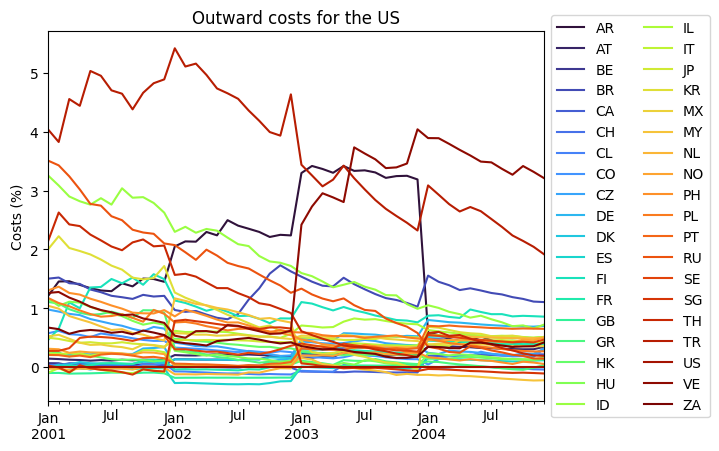

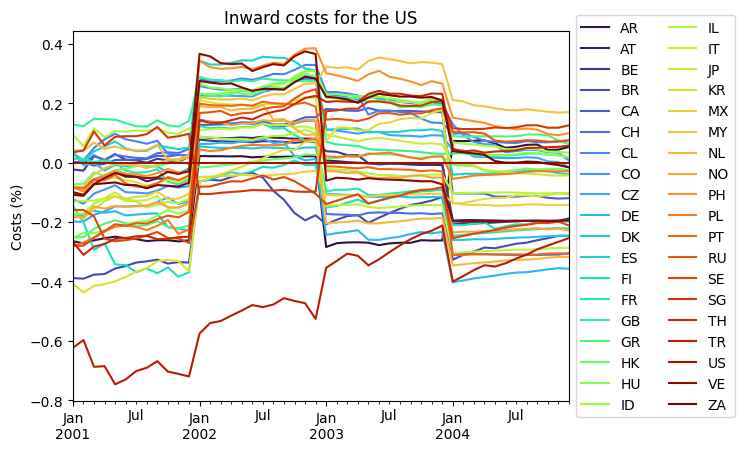

In [68]:
import matplotlib.cm as cm
data_outward = costs.loc[slice(None), (slice(None), "US")].T.droplevel(level=1)
data_inward = costs.loc["US"].unstack()
color = plt.get_cmap("turbo", 38)
ax = data_outward.plot(title="Outward costs for the US", ylabel="Costs (%)", colormap=color)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2)
ax = data_inward.plot(title="Inward costs for the US", ylabel="Costs (%)", colormap=color)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2)
plt.show()

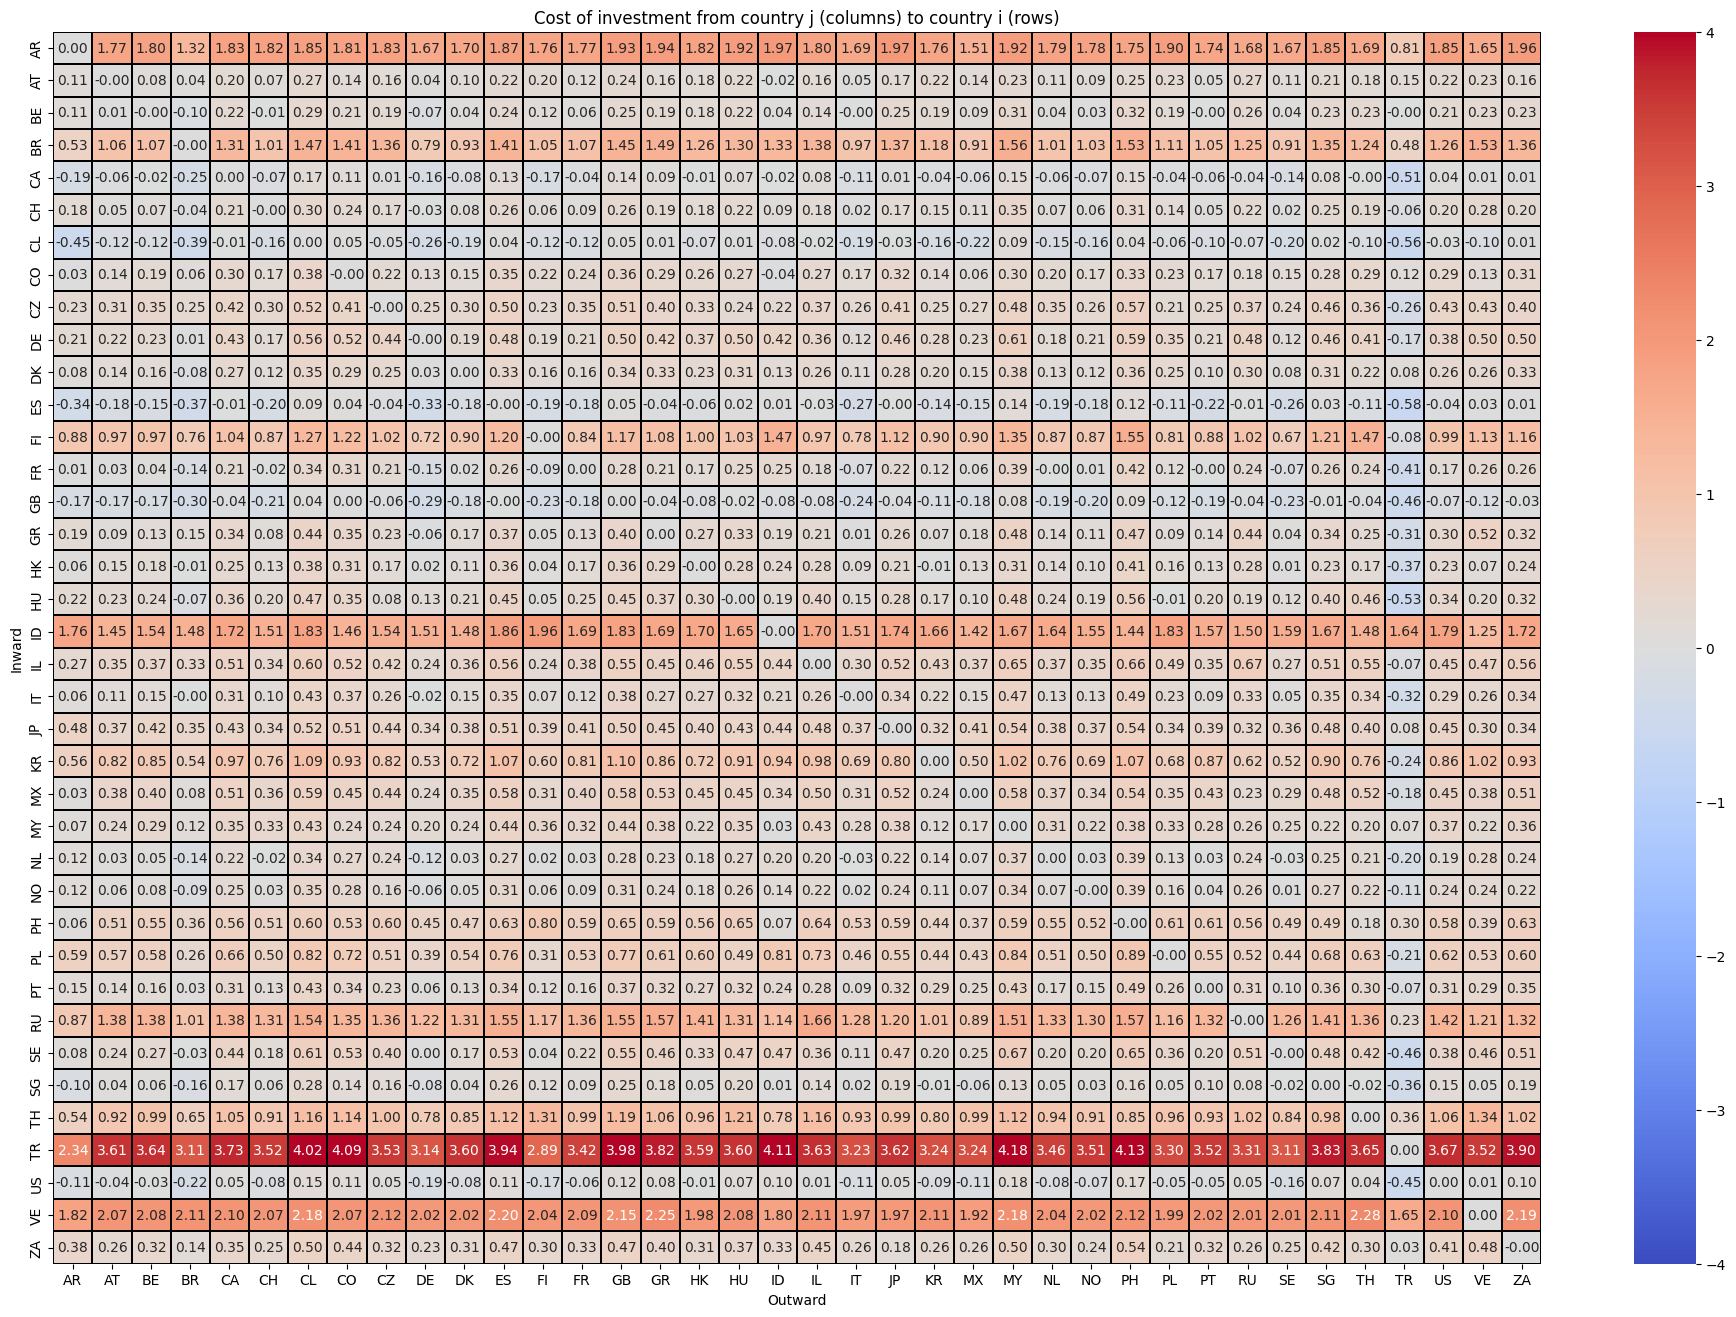

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
costs_mean = costs.T.groupby(level=1).mean().T
costs_mean = costs_mean.astype(float)
# Heatmap
plt.figure(figsize=(24, 16))
sns.heatmap(costs_mean, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, vmin=-4, vmax=4, linewidths=0.1, linecolor='black')
plt.title('Cost of investment from country j (columns) to country i (rows)')
plt.xlabel("Outward")
plt.ylabel("Inward")
plt.show()

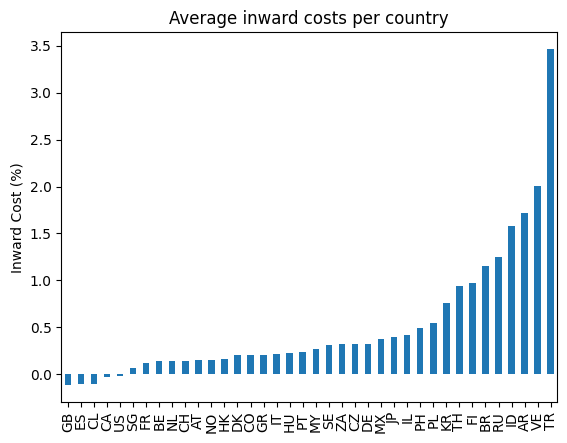

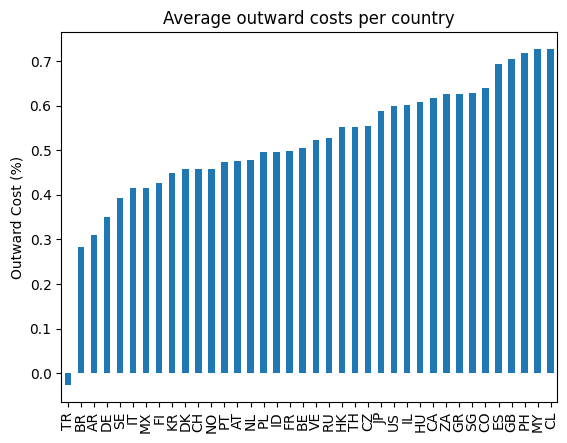

In [116]:
mean_inward_cost = costs_mean.mean(axis=1).sort_values()
mean_outward_cost = costs_mean.mean(axis=0).sort_values()
import matplotlib.cm as cm
import matplotlib.colors as colors
color = False
norm = colors.Normalize(vmin=-4, vmax=4)
cmap = cm.coolwarm
plt.figure()
bar_colors = cmap(norm(mean_inward_cost.values))
mean_inward_cost.plot(kind="bar", edgecolor=("black" if color else None), color=(bar_colors if color else None), title="Average inward costs per country", ylabel="Inward Cost (%)")
plt.figure()
bar_colors = cmap(norm(mean_outward_cost.values))
mean_outward_cost.plot(kind="bar", edgecolor=("black" if color else None), color=(bar_colors if color else None), title="Average outward costs per country", ylabel="Outward Cost (%)")
plt.show()

In [117]:
print("average over means: ", (costs_mean<0).sum().sum()/38**2)
print("average over all obs.: ", (costs_9<0).sum().sum()/38**2/48)

average over means:  0.1440443213296399
average over all obs.:  0.22866170360110805


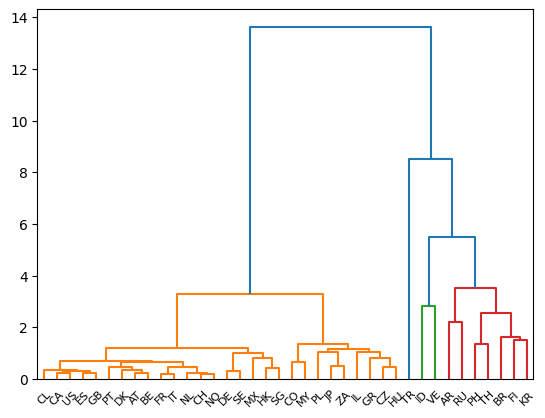

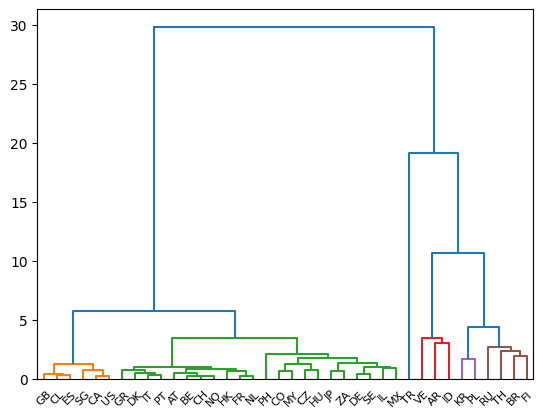

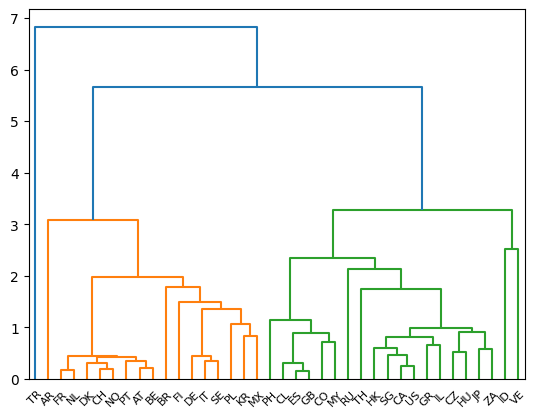

In [118]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Based on average cost between i and j
A = (costs_mean + costs_mean.T)/2 + 1
Z = linkage(A, method='ward')
dendrogram(Z, color_threshold=4, labels=major)
plt.show()

# Based on rows = inward costs
A = costs_mean
Z = linkage(A, method='ward')
dendrogram(Z, color_threshold=4, labels=major)
plt.show()

# Based on columns = outward costs
A = costs_mean.T
Z = linkage(A, method='ward')
dendrogram(Z, color_threshold=4, labels=major)
plt.show()